In [ ]:
!pip install torch pandas numpy matplotlib scikit-learn yfinance ta optuna

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import math
import optuna

from sklearn.preprocessing import MinMaxScaler
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set styling for plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

from IPython.display import display


Using device: cuda


In [ ]:
class StockDataset:
    def __init__(self, ticker, start_date='2015-01-01', end_date='2024-01-01', window_size=60):
        self.ticker = ticker
        self.window_size = window_size
        #self.scaler_X = StandardScaler()
        #self.scaler_y = StandardScaler()
        self.scaler_X = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))

        # 1. Fetch Data
        print(f"Downloading data for {ticker}...")
        self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

        # 2. Feature Engineering
        self.df = self._add_technical_indicators(self.raw_df)

        # 3. Preprocessing
        self.X, self.y = self._create_sequences()

    def _add_technical_indicators(self, df):
        df = df.copy()
        # Handle MultiIndex columns if yfinance returns them
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        close = df['Close']

        # RSI (Momentum)
        rsi = RSIIndicator(close=close, window=14)
        df['RSI'] = rsi.rsi()

        # MACD (Trend)
        macd = MACD(close=close)
        df['MACD'] = macd.macd()

        # SMA (Smoothing)
        sma = SMAIndicator(close=close, window=20)
        df['SMA_20'] = sma.sma_indicator()

        # Drop NaN values created by indicators
        df = df.dropna()

        # Features to use for prediction
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'SMA_20']
        return df[features]

    def _create_sequences(self):
        data = self.df.values
        target = self.df['Close'].values.reshape(-1, 1)

        # 1. Define the split point (e.g., first 80% is for training)
        train_size = int(len(data) * 0.8)

        # 2. Fit the scaler ONLY on the training portion
        # This calculates mean/std using only past data, preventing leakage
        self.scaler_X.fit(data[:train_size])
        self.scaler_y.fit(target[:train_size])

        # 3. Transform the ENTIRE dataset using those learned parameters
        data_normalized = self.scaler_X.transform(data)
        target_normalized = self.scaler_y.transform(target)

        X, y = [], []
        # Sliding Window Logic (remains the same)
        for i in range(len(data_normalized) - self.window_size):
            # Input: Window of 'window_size' days
            X.append(data_normalized[i:i+self.window_size])
            # Target: The Close price of the NEXT day
            y.append(target_normalized[i+self.window_size])

        return np.array(X), np.array(y)

    def get_loaders(self, batch_size=32):
        # Split 80/10/10
        split1 = int(len(self.X) * 0.8)
        split2 = int(len(self.X) * 0.9)

        X_train, y_train = self.X[:split1], self.y[:split1]
        X_val, y_val = self.X[split1:split2], self.y[split1:split2]
        X_test, y_test = self.X[split2:], self.y[split2:]

        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()),
                                  batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()),
                                batch_size=batch_size)
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()),
                                 batch_size=batch_size)

        return train_loader, val_loader, test_loader, X_train.shape[2]

In [ ]:
# --- 1. Recurrent Models (RNN/LSTM/GRU) ---
class RecurrentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, model_type="LSTM"):
        super(RecurrentModel, self).__init__()
        self.model_type = model_type
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        if model_type == "RNN":
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        if self.model_type == "LSTM":
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# --- 2. Standard Transformer ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :] # Use last token
        output = self.decoder(output)
        return output

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, patience=5):


    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_out = model(x_val)
                val_loss = criterion(val_out, y_val)
                val_batch_losses.append(val_loss.item())

        val_loss = np.mean(val_batch_losses)
        val_losses.append(val_loss)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model state
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
        else:
            patience_counter += 1

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    return model, train_losses, val_losses

def evaluate_model(model, test_loader, scaler_y):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            out = model(x_test).cpu().numpy()
            predictions.append(out)
            actuals.append(y_test.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Inverse Transform to get actual prices
    predictions_prices = scaler_y.inverse_transform(predictions)
    actuals_prices = scaler_y.inverse_transform(actuals)

    return predictions_prices, actuals_prices

In [ ]:
# --- CONFIGURATION (Multi-ticker) ---
TICKERS = ["NVDA", "KO", "JPM"]
WINDOW = 60
BATCH = 64

# Containers to keep everything per ticker
all_results = {}
all_predictions = {}
all_actuals = {}

for TARGET_TICKER in TICKERS:
    print(f"\n==============================")
    print(f"--- Processing {TARGET_TICKER} ---")
    print(f"==============================\n")

    # 1. Setup Data
    dataset = StockDataset(TARGET_TICKER, window_size=WINDOW)
    train_loader, val_loader, test_loader, input_dim = dataset.get_loaders(batch_size=BATCH)

    # 2. Setup Models (sensible defaults)
    models_to_train = {
        "RNN": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="RNN").to(device),
        "LSTM": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="LSTM").to(device),
        "GRU": RecurrentModel(input_dim, hidden_dim=64, layer_dim=2, output_dim=1, dropout_prob=0.2, model_type="GRU").to(device),
        "Transformer": TimeSeriesTransformer(input_dim, d_model=64, nhead=4, num_layers=2, output_dim=1, dropout=0.1).to(device),
    }

    results = {}
    predictions_store = {}
    actuals_store = None

    # 3. Training Loop (train each model independently on the same ticker data)
    for name, model in models_to_train.items():
        print(f"\n>> Training {name} on {TARGET_TICKER}...")

        trained_model, t_loss, v_loss = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=30,
            lr=0.001,
            patience=5
        )

        # Evaluate
        preds, actuals = evaluate_model(trained_model, test_loader, dataset.scaler_y)
        actuals_store = actuals

        # Metrics
        mse = np.mean((preds - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(preds - actuals))

        results[name] = {"RMSE": rmse, "MAE": mae}
        predictions_store[name] = preds

        print(f"{name} Performance -> RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    print("\nAll models trained for", TARGET_TICKER)

    # Persist per-ticker artifacts
    all_results[TARGET_TICKER] = results
    all_predictions[TARGET_TICKER] = predictions_store
    all_actuals[TARGET_TICKER] = actuals_store

print("\nDone. Trained all tickers:", ", ".join(TICKERS))



--- Processing NVDA ---


>> Training RNN on NVDA...


/tmp/ipython-input-2366191267.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Epoch 5/30 | Train Loss: 0.001322 | Val Loss: 0.000987
Epoch 10/30 | Train Loss: 0.000704 | Val Loss: 0.001026
Epoch 15/30 | Train Loss: 0.000546 | Val Loss: 0.000775
Epoch 20/30 | Train Loss: 0.000413 | Val Loss: 0.000886
Early stopping triggered.
RNN Performance -> RMSE: 4.8053 | MAE: 4.0773

>> Training LSTM on NVDA...
Epoch 5/30 | Train Loss: 0.000550 | Val Loss: 0.002923
Epoch 10/30 | Train Loss: 0.000518 | Val Loss: 0.001384
Epoch 15/30 | Train Loss: 0.000435 | Val Loss: 0.001192
Epoch 20/30 | Train Loss: 0.000281 | Val Loss: 0.001131
Early stopping triggered.
LSTM Performance -> RMSE: 4.2473 | MAE: 3.4898

>> Training GRU on NVDA...
Epoch 5/30 | Train Loss: 0.000452 | Val Loss: 0.001165
Epoch 10/30 | Train Loss: 0.000369 | Val Loss: 0.001143
Early stopping triggered.
GRU Performance -> RMSE: 3.6896 | MAE: 3.0629

>> Training Transformer on NVDA...
Epoch 5/30 | Train Loss: 0.004023 | Val Loss: 0.001669
Epoch 10/30 | Train Loss: 0.002106 | Val Loss: 0.001463
Epoch 15/30 | Train Lo

/tmp/ipython-input-2366191267.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)



>> Training RNN on KO...
Epoch 5/30 | Train Loss: 0.001616 | Val Loss: 0.005274
Epoch 10/30 | Train Loss: 0.001241 | Val Loss: 0.001447
Epoch 15/30 | Train Loss: 0.000891 | Val Loss: 0.002431
Early stopping triggered.
RNN Performance -> RMSE: 0.6035 | MAE: 0.4710

>> Training LSTM on KO...
Epoch 5/30 | Train Loss: 0.001441 | Val Loss: 0.001962
Epoch 10/30 | Train Loss: 0.001165 | Val Loss: 0.001355
Epoch 15/30 | Train Loss: 0.000921 | Val Loss: 0.001154
Epoch 20/30 | Train Loss: 0.000904 | Val Loss: 0.001599
Early stopping triggered.
LSTM Performance -> RMSE: 0.5803 | MAE: 0.4437

>> Training GRU on KO...
Epoch 5/30 | Train Loss: 0.001100 | Val Loss: 0.001984
Epoch 10/30 | Train Loss: 0.000836 | Val Loss: 0.001109
Epoch 15/30 | Train Loss: 0.000755 | Val Loss: 0.000883
Epoch 20/30 | Train Loss: 0.000643 | Val Loss: 0.000832
Epoch 25/30 | Train Loss: 0.000614 | Val Loss: 0.002019
Early stopping triggered.
GRU Performance -> RMSE: 0.5281 | MAE: 0.4070

>> Training Transformer on KO...
E

/tmp/ipython-input-2366191267.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.raw_df = yf.download(ticker, start=start_date, end=end_date, progress=False)



>> Training RNN on JPM...
Epoch 5/30 | Train Loss: 0.001223 | Val Loss: 0.000622
Epoch 10/30 | Train Loss: 0.000901 | Val Loss: 0.000622
Epoch 15/30 | Train Loss: 0.000695 | Val Loss: 0.000514
Epoch 20/30 | Train Loss: 0.000555 | Val Loss: 0.000420
Epoch 25/30 | Train Loss: 0.000427 | Val Loss: 0.000452
Epoch 30/30 | Train Loss: 0.000467 | Val Loss: 0.000430
RNN Performance -> RMSE: 2.2144 | MAE: 1.6957

>> Training LSTM on JPM...
Epoch 5/30 | Train Loss: 0.001283 | Val Loss: 0.001395
Epoch 10/30 | Train Loss: 0.000877 | Val Loss: 0.001217
Epoch 15/30 | Train Loss: 0.000805 | Val Loss: 0.000913
Epoch 20/30 | Train Loss: 0.000762 | Val Loss: 0.001090
Epoch 25/30 | Train Loss: 0.000635 | Val Loss: 0.000836
Early stopping triggered.
LSTM Performance -> RMSE: 2.8967 | MAE: 2.2616

>> Training GRU on JPM...
Epoch 5/30 | Train Loss: 0.000895 | Val Loss: 0.000852
Epoch 10/30 | Train Loss: 0.000730 | Val Loss: 0.000740
Epoch 15/30 | Train Loss: 0.000595 | Val Loss: 0.000624
Epoch 20/30 | Trai

,Ticker,Model,RMSE,MAE
11,JPM,Transformer,1.977350,1.454659
8,JPM,RNN,2.214401,1.695726
10,JPM,GRU,2.444722,1.886917
9,JPM,LSTM,2.896708,2.261623
6,KO,GRU,0.528123,0.407034
7,KO,Transformer,0.543257,0.421012
5,KO,LSTM,0.580345,0.443668
4,KO,RNN,0.603500,0.470974
2,NVDA,GRU,3.689560,3.062855
1,NVDA,LSTM,4.247264,3.489799


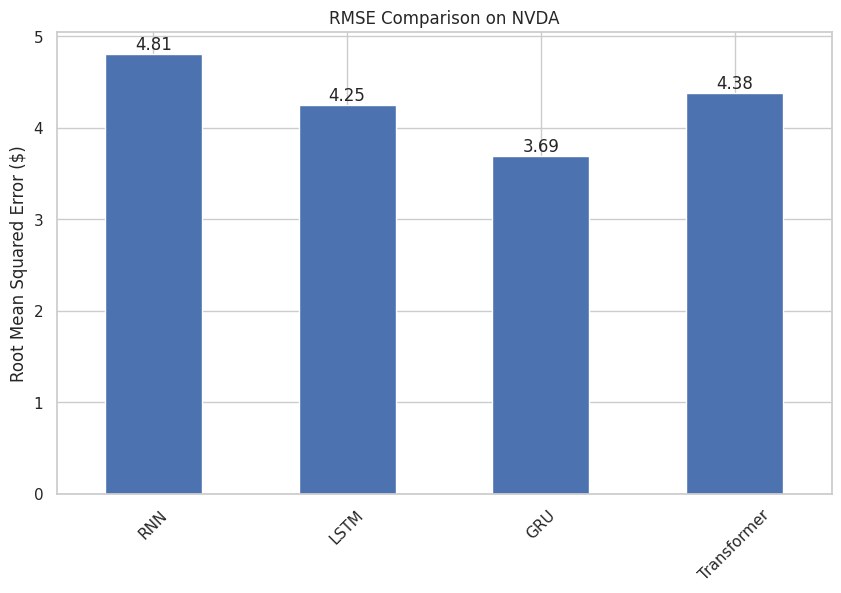

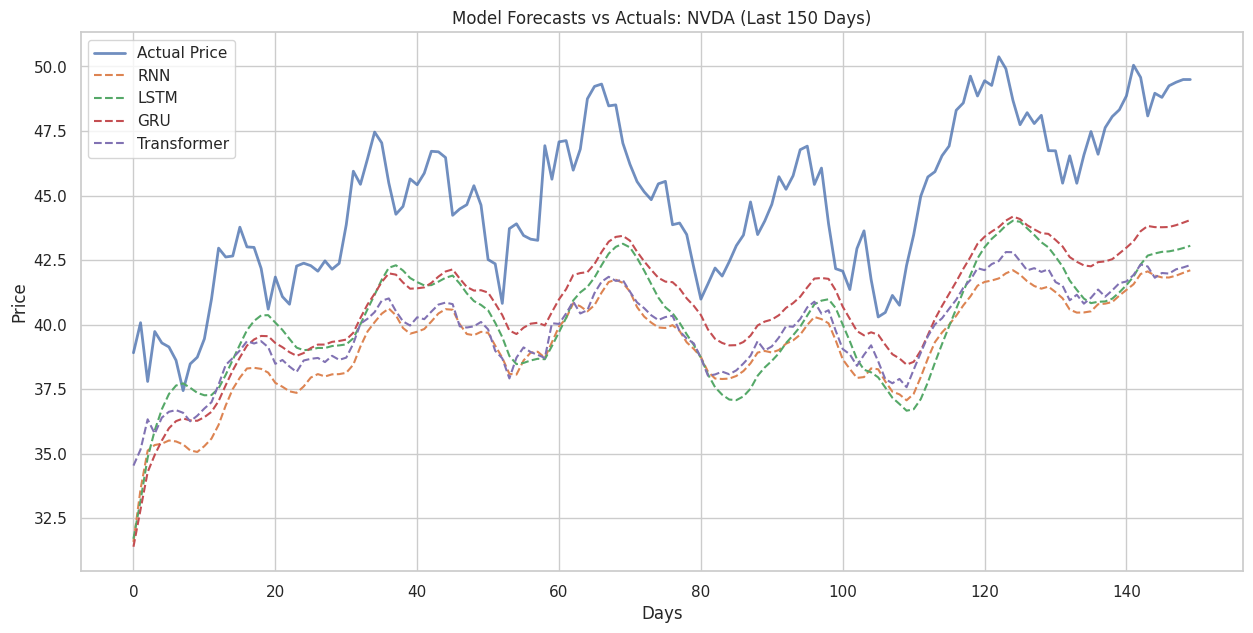

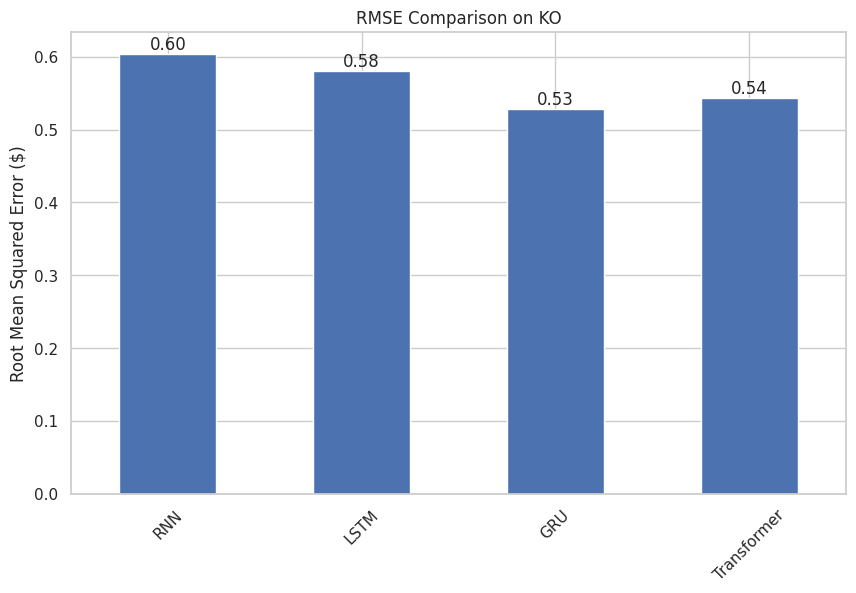

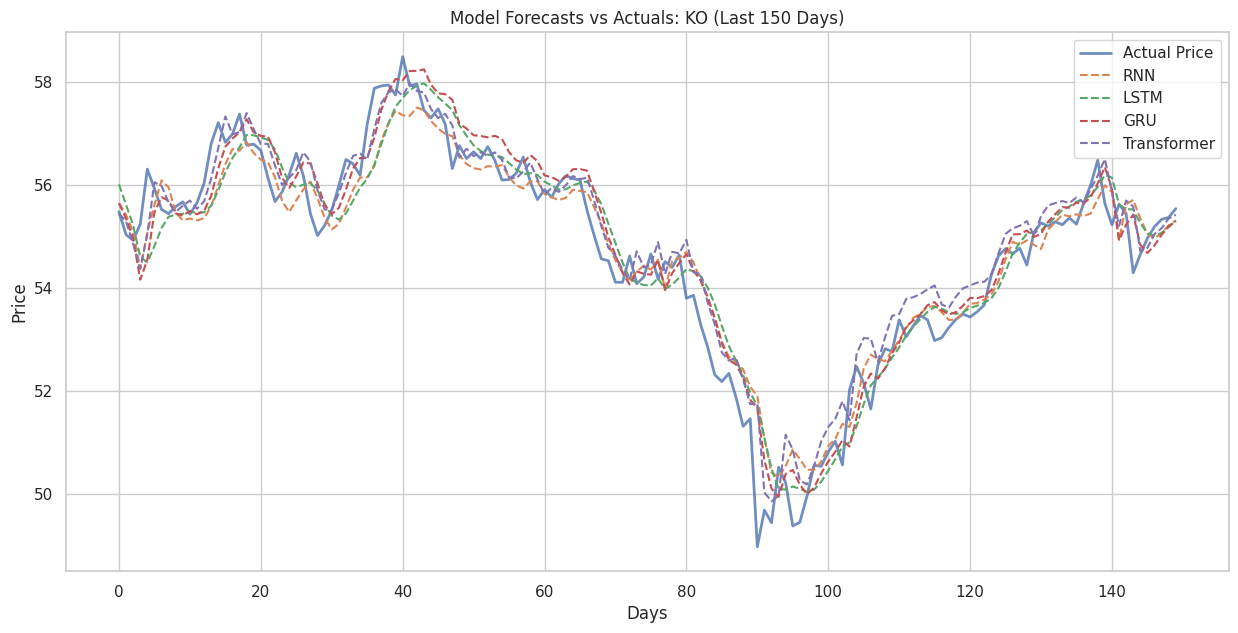

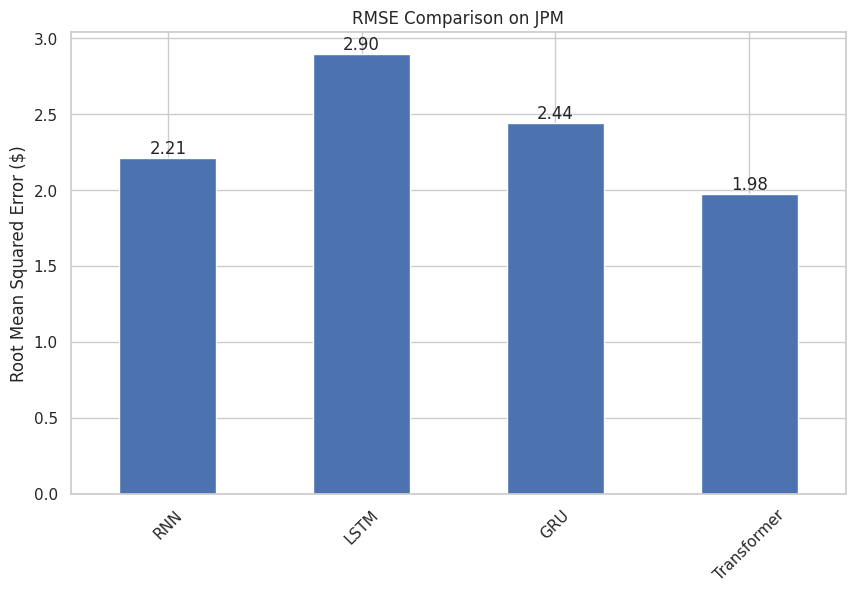

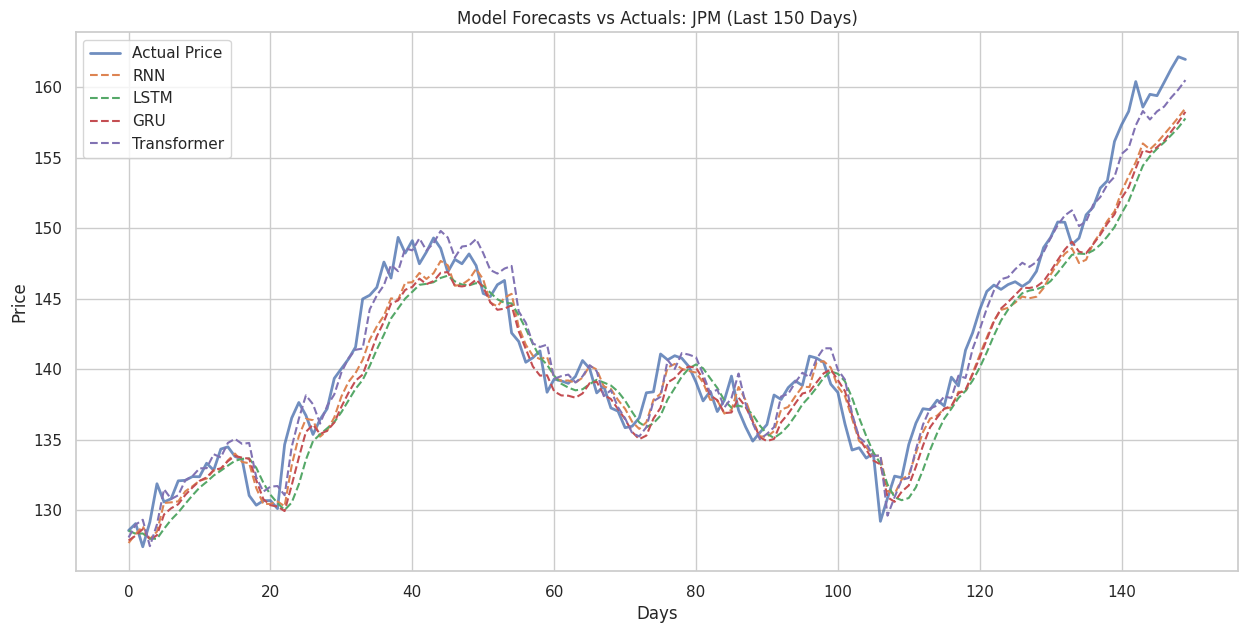

In [ ]:
# --- PLOTTING (Per Ticker) ---

# Optional: summary table across tickers (rows=tickers, columns=model-metric)
summary_rows = []
for ticker, res in all_results.items():
    for model_name, metrics in res.items():
        summary_rows.append({
            "Ticker": ticker,
            "Model": model_name,
            "RMSE": metrics["RMSE"],
            "MAE": metrics["MAE"],
        })

summary_df = pd.DataFrame(summary_rows)
display(summary_df.sort_values(["Ticker", "RMSE"]))

for TARGET_TICKER in TICKERS:
    results = all_results[TARGET_TICKER]
    predictions_store = all_predictions[TARGET_TICKER]
    actuals = all_actuals[TARGET_TICKER]

    # 1. Comparison Bar Chart
    metrics_df = pd.DataFrame(results).T
    plt.figure(figsize=(10, 6))
    metrics_df["RMSE"].plot(kind="bar")
    plt.title(f"RMSE Comparison on {TARGET_TICKER}")
    plt.ylabel("Root Mean Squared Error ($)")
    plt.xticks(rotation=45)
    for i, v in enumerate(metrics_df["RMSE"].values):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
    plt.show()

    # 2. Prediction Overlay
    plt.figure(figsize=(15, 7))
    zoom = 150
    plt.plot(actuals[-zoom:], label="Actual Price", linewidth=2, alpha=0.8)

    for name, preds in predictions_store.items():
        plt.plot(preds[-zoom:], label=name, linestyle="--")

    plt.title(f"Model Forecasts vs Actuals: {TARGET_TICKER} (Last {zoom} Days)")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.show()


/tmp/ipython-input-843238408.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


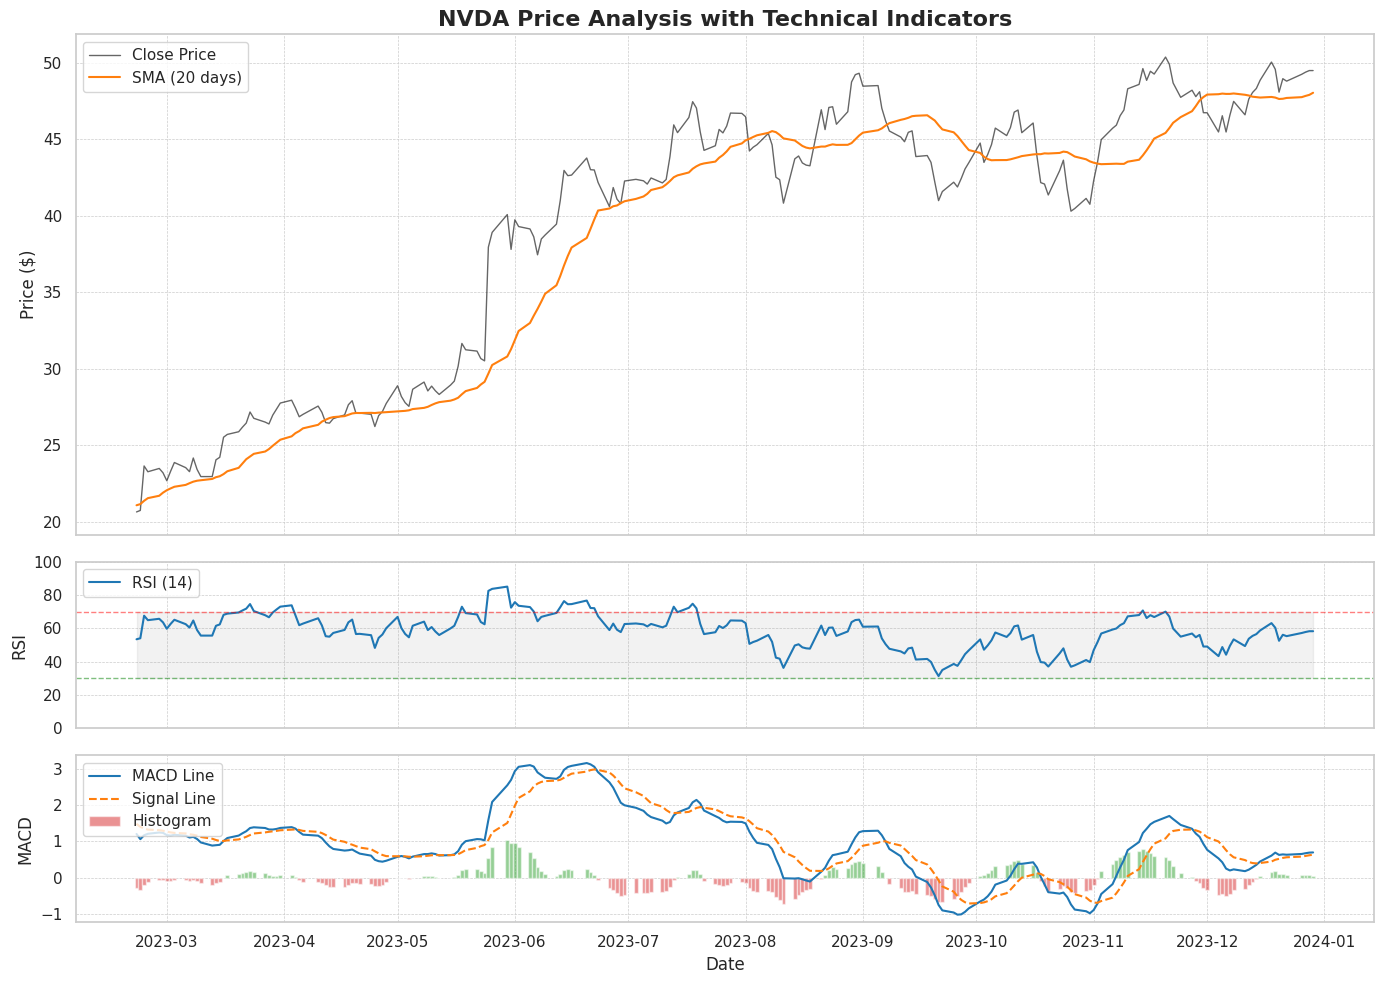

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator

# --- Configuration ---
TICKER = "NVDA"
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

def fetch_and_process_data(ticker, start, end):
    """
    Fetches data and calculates indicators matching the StockDataset logic.
    """
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Handle MultiIndex columns if yfinance returns them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Ensure we have data
    if df.empty:
        raise ValueError("No data fetched. Check ticker or date range.")

    close = df['Close']

    # --- 1. Calculate SMA (Smoothing) ---
    # Matches: sma = SMAIndicator(close=close, window=20)
    sma = SMAIndicator(close=close, window=20)
    df['SMA_20'] = sma.sma_indicator()

    # --- 2. Calculate RSI (Momentum) ---
    # Matches: rsi = RSIIndicator(close=close, window=14)
    rsi = RSIIndicator(close=close, window=14)
    df['RSI'] = rsi.rsi()

    # --- 3. Calculate MACD (Trend) ---
    # Matches: macd = MACD(close=close)
    macd_indicator = MACD(close=close)
    df['MACD'] = macd_indicator.macd()
    df['MACD_Signal'] = macd_indicator.macd_signal()
    df['MACD_Hist'] = macd_indicator.macd_diff()

    # Remove NaN values generated by the indicators (first 20-30 days)
    df = df.dropna()

    return df

def plot_technical_analysis(df, ticker):
    """
    Generates a professional 3-panel plot: Price/SMA, RSI, and MACD.
    """
    # Set up the figure layout (3 rows, shared x-axis)
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])

    # --- Panel 1: Price & SMA ---
    ax0 = plt.subplot(gs[0])
    ax0.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.6, linewidth=1)
    ax0.plot(df.index, df['SMA_20'], label='SMA (20 days)', color='#ff7f0e', linewidth=1.5)
    ax0.set_title(f'{ticker} Price Analysis with Technical Indicators', fontsize=16, fontweight='bold')
    ax0.set_ylabel('Price ($)', fontsize=12)
    ax0.legend(loc='upper left')
    ax0.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.setp(ax0.get_xticklabels(), visible=False) # Hide x-labels for top plot

    # --- Panel 2: RSI ---
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(df.index, df['RSI'], label='RSI (14)', color='#1f77b4')

    # Add reference lines for Overbought (70) and Oversold (30)
    ax1.axhline(70, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax1.fill_between(df.index, 70, 30, color='gray', alpha=0.1) # Shaded region

    ax1.set_ylabel('RSI', fontsize=12)
    ax1.set_ylim(0, 100)
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', linewidth=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)

    # --- Panel 3: MACD ---
    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(df.index, df['MACD'], label='MACD Line', color='#1f77b4', linewidth=1.5)
    ax2.plot(df.index, df['MACD_Signal'], label='Signal Line', color='#ff7f0e', linestyle='--', linewidth=1.5)

    # Colorize histogram bars (Green for positive, Red for negative)
    colors = ['#2ca02c' if v >= 0 else '#d62728' for v in df['MACD_Hist']]
    ax2.bar(df.index, df['MACD_Hist'], color=colors, alpha=0.5, label='Histogram', width=1.0)

    ax2.set_ylabel('MACD', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Final Layout Adjustments
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    try:
        # 1. Get Data
        data = fetch_and_process_data(TICKER, START_DATE, END_DATE)

        # 2. Plot
        plot_technical_analysis(data, TICKER)

    except Exception as e:
        print(f"Error: {e}")
        print("Ensure you have the required libraries installed: pip install yfinance matplotlib pandas ta")

/tmp/ipython-input-3544314829.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


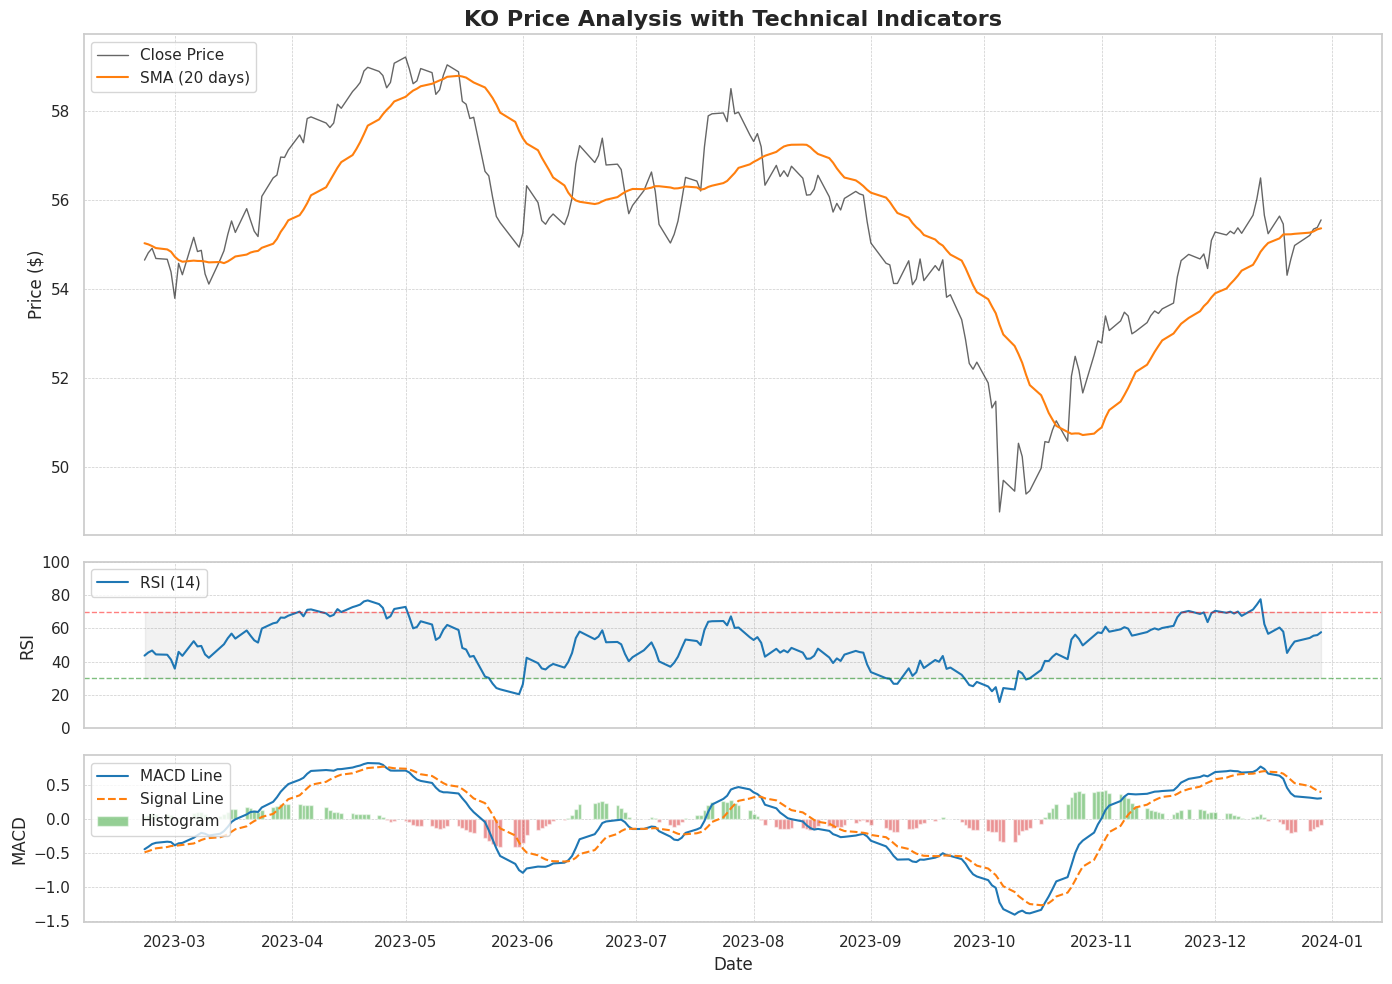

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator

# --- Configuration ---
TICKER = "KO"
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

def fetch_and_process_data(ticker, start, end):
    """
    Fetches data and calculates indicators matching the StockDataset logic.
    """
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Handle MultiIndex columns if yfinance returns them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Ensure we have data
    if df.empty:
        raise ValueError("No data fetched. Check ticker or date range.")

    close = df['Close']

    # --- 1. Calculate SMA (Smoothing) ---
    # Matches: sma = SMAIndicator(close=close, window=20)
    sma = SMAIndicator(close=close, window=20)
    df['SMA_20'] = sma.sma_indicator()

    # --- 2. Calculate RSI (Momentum) ---
    # Matches: rsi = RSIIndicator(close=close, window=14)
    rsi = RSIIndicator(close=close, window=14)
    df['RSI'] = rsi.rsi()

    # --- 3. Calculate MACD (Trend) ---
    # Matches: macd = MACD(close=close)
    macd_indicator = MACD(close=close)
    df['MACD'] = macd_indicator.macd()
    df['MACD_Signal'] = macd_indicator.macd_signal()
    df['MACD_Hist'] = macd_indicator.macd_diff()

    # Remove NaN values generated by the indicators (first 20-30 days)
    df = df.dropna()

    return df

def plot_technical_analysis(df, ticker):
    """
    Generates a professional 3-panel plot: Price/SMA, RSI, and MACD.
    """
    # Set up the figure layout (3 rows, shared x-axis)
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])

    # --- Panel 1: Price & SMA ---
    ax0 = plt.subplot(gs[0])
    ax0.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.6, linewidth=1)
    ax0.plot(df.index, df['SMA_20'], label='SMA (20 days)', color='#ff7f0e', linewidth=1.5)
    ax0.set_title(f'{ticker} Price Analysis with Technical Indicators', fontsize=16, fontweight='bold')
    ax0.set_ylabel('Price ($)', fontsize=12)
    ax0.legend(loc='upper left')
    ax0.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.setp(ax0.get_xticklabels(), visible=False) # Hide x-labels for top plot

    # --- Panel 2: RSI ---
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(df.index, df['RSI'], label='RSI (14)', color='#1f77b4')

    # Add reference lines for Overbought (70) and Oversold (30)
    ax1.axhline(70, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax1.fill_between(df.index, 70, 30, color='gray', alpha=0.1) # Shaded region

    ax1.set_ylabel('RSI', fontsize=12)
    ax1.set_ylim(0, 100)
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', linewidth=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)

    # --- Panel 3: MACD ---
    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(df.index, df['MACD'], label='MACD Line', color='#1f77b4', linewidth=1.5)
    ax2.plot(df.index, df['MACD_Signal'], label='Signal Line', color='#ff7f0e', linestyle='--', linewidth=1.5)

    # Colorize histogram bars (Green for positive, Red for negative)
    colors = ['#2ca02c' if v >= 0 else '#d62728' for v in df['MACD_Hist']]
    ax2.bar(df.index, df['MACD_Hist'], color=colors, alpha=0.5, label='Histogram', width=1.0)

    ax2.set_ylabel('MACD', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Final Layout Adjustments
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    try:
        # 1. Get Data
        data = fetch_and_process_data(TICKER, START_DATE, END_DATE)

        # 2. Plot
        plot_technical_analysis(data, TICKER)

    except Exception as e:
        print(f"Error: {e}")
        print("Ensure you have the required libraries installed: pip install yfinance matplotlib pandas ta")

/tmp/ipython-input-1113995330.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


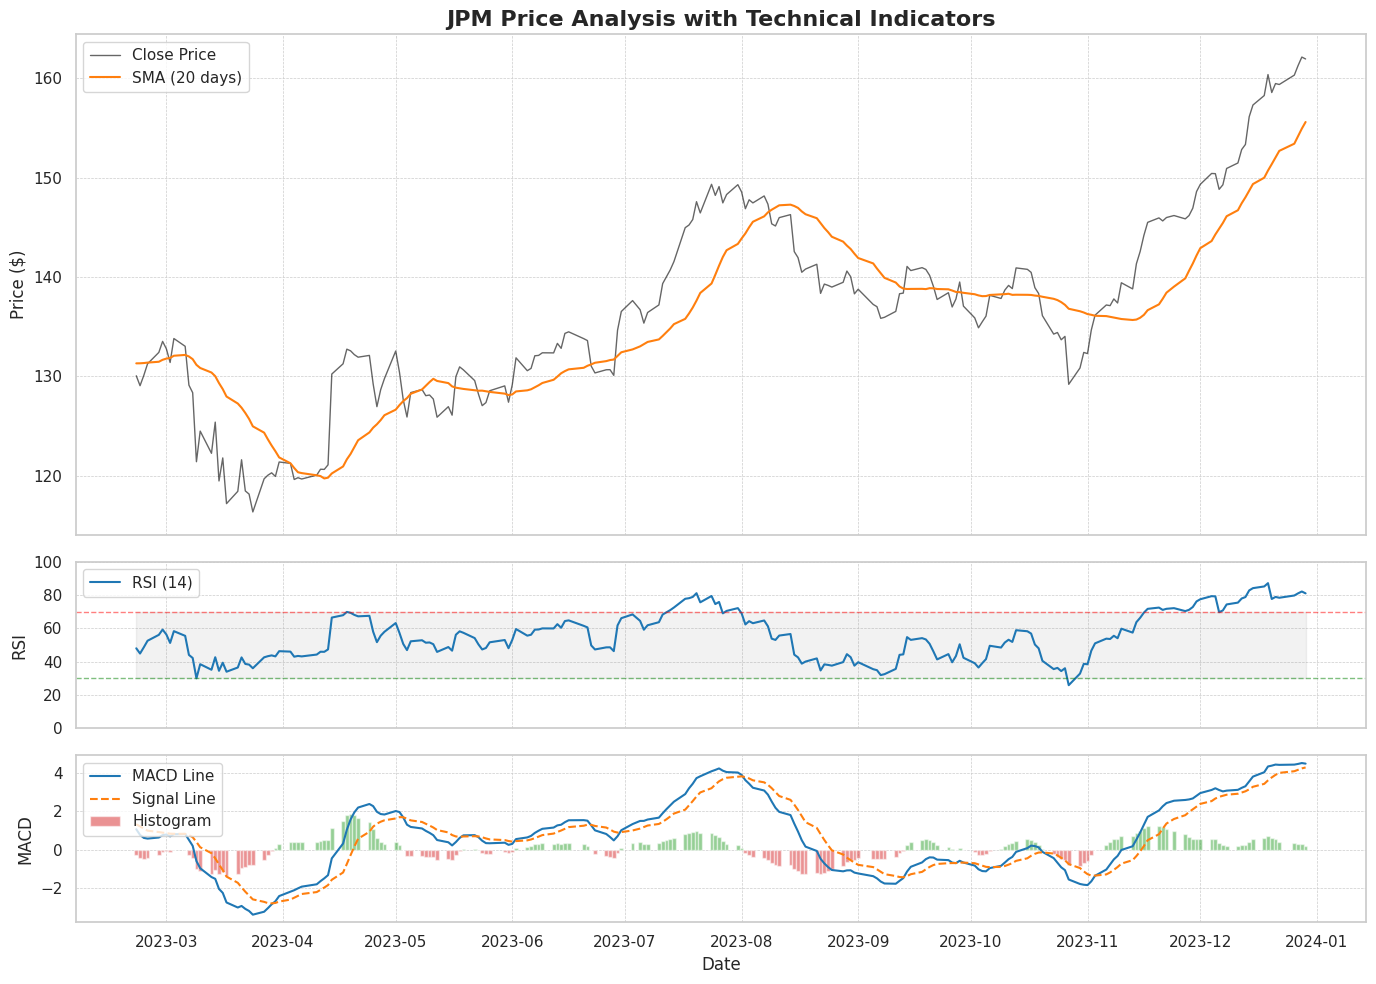

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator

# --- Configuration ---
TICKER = "JPM"
START_DATE = "2023-01-01"
END_DATE = "2024-01-01"

def fetch_and_process_data(ticker, start, end):
    """
    Fetches data and calculates indicators matching the StockDataset logic.
    """
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    # Handle MultiIndex columns if yfinance returns them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Ensure we have data
    if df.empty:
        raise ValueError("No data fetched. Check ticker or date range.")

    close = df['Close']

    # --- 1. Calculate SMA (Smoothing) ---
    # Matches: sma = SMAIndicator(close=close, window=20)
    sma = SMAIndicator(close=close, window=20)
    df['SMA_20'] = sma.sma_indicator()

    # --- 2. Calculate RSI (Momentum) ---
    # Matches: rsi = RSIIndicator(close=close, window=14)
    rsi = RSIIndicator(close=close, window=14)
    df['RSI'] = rsi.rsi()

    # --- 3. Calculate MACD (Trend) ---
    # Matches: macd = MACD(close=close)
    macd_indicator = MACD(close=close)
    df['MACD'] = macd_indicator.macd()
    df['MACD_Signal'] = macd_indicator.macd_signal()
    df['MACD_Hist'] = macd_indicator.macd_diff()

    # Remove NaN values generated by the indicators (first 20-30 days)
    df = df.dropna()

    return df

def plot_technical_analysis(df, ticker):
    """
    Generates a professional 3-panel plot: Price/SMA, RSI, and MACD.
    """
    # Set up the figure layout (3 rows, shared x-axis)
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])

    # --- Panel 1: Price & SMA ---
    ax0 = plt.subplot(gs[0])
    ax0.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.6, linewidth=1)
    ax0.plot(df.index, df['SMA_20'], label='SMA (20 days)', color='#ff7f0e', linewidth=1.5)
    ax0.set_title(f'{ticker} Price Analysis with Technical Indicators', fontsize=16, fontweight='bold')
    ax0.set_ylabel('Price ($)', fontsize=12)
    ax0.legend(loc='upper left')
    ax0.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.setp(ax0.get_xticklabels(), visible=False) # Hide x-labels for top plot

    # --- Panel 2: RSI ---
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(df.index, df['RSI'], label='RSI (14)', color='#1f77b4')

    # Add reference lines for Overbought (70) and Oversold (30)
    ax1.axhline(70, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax1.fill_between(df.index, 70, 30, color='gray', alpha=0.1) # Shaded region

    ax1.set_ylabel('RSI', fontsize=12)
    ax1.set_ylim(0, 100)
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', linewidth=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)

    # --- Panel 3: MACD ---
    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(df.index, df['MACD'], label='MACD Line', color='#1f77b4', linewidth=1.5)
    ax2.plot(df.index, df['MACD_Signal'], label='Signal Line', color='#ff7f0e', linestyle='--', linewidth=1.5)

    # Colorize histogram bars (Green for positive, Red for negative)
    colors = ['#2ca02c' if v >= 0 else '#d62728' for v in df['MACD_Hist']]
    ax2.bar(df.index, df['MACD_Hist'], color=colors, alpha=0.5, label='Histogram', width=1.0)

    ax2.set_ylabel('MACD', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Final Layout Adjustments
    plt.tight_layout()
    plt.show()

# --- Execution ---
if __name__ == "__main__":
    try:
        # 1. Get Data
        data = fetch_and_process_data(TICKER, START_DATE, END_DATE)

        # 2. Plot
        plot_technical_analysis(data, TICKER)

    except Exception as e:
        print(f"Error: {e}")
        print("Ensure you have the required libraries installed: pip install yfinance matplotlib pandas ta")